<a href="https://colab.research.google.com/github/Harry-cheong/Legosorter/blob/main/Lego_Sorter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI+ 2021 TD3 Assessment 2 [35%]

**Requirements**
* ideate an AI project
* implement it from end to end
* collect and prepare data
* perform training and testing
* evaluation performance
* deploy to real users
* document all phases
* show understanding of concepts and skills (this is Google Colab, so please show code!)
* frameworks introduced during the module (eg Tensorflow, PyTorch, etc.)
* and more (your exploration)
* teach it to high school students (so that they can also learn enough AI from you to create an end-to-end project)


**AI Project**

[Goal: Our plan is to create an Ai to find lego parts.]

[Context: In our cca, it is a common sight for the robotics room to be messy and overflowing with lego parts.]

[Our project: Our plan is to make an ai to find parts that we need from a pile of miscellaneous parts. During my experience in robotics club, sorting or finding parts are strenuous and tedious. During the competiton sessions, we struggle to find the required parts to build our robot, impeding our preparation efforts]

[In the Future: I hope that with concerted effort, my cca can ultimately create a simplified full scale sorting machine to tackle this problem.]

- Collect and prepare data

[augmented data collection - using sythetic data generated with the aid of a 3D model]

- Machine learning model

[CNN - Convolutional Neural Network, Tensorflow, keras, YOLO, InceptionV3]

**Github Repository :** https://github.com/Harry-cheong/AIWinpetition_Teamno_legosorter

**Implementing Our Project**

---






For the project, we unfortunately do not have the time to train a machine learning model capable of identifying all LEGO parts out there. Therefore, We have decided that we will create a scalable AI model that could identify at least one lego part as a proof of concept. This project was really difficult for us because generating synthetic data and object detection with deep learning are areas where we have not had any experience with.

**Our data**

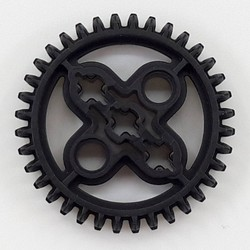

**Specifications**:
LEGO PART 32498 Technic Gear 36 Tooth Double Bevel

**Google Drive Link** : https://drive.google.com/file/d/1ZzfZZ1GaIMNOzXDe9vXJzEbTH23yg0dR/view?usp=sharing

**3D file Generated by**: https://www.mecabricks.com/ru/workshop/

The 3D file we used to generate our synthetic dataset is obtained on a Russian website as it was extremely challenging to find a 3D model that has the file type .dae. Most of the lego 3D model are all based on the LDraw format (.dat file).

**Data Collection and Preparation**



**Domain Randomization :** Render 3D model while jitterring camera, object, HSV and using different background.

**Software used :** Blender

**Python Libraries :**

bpy (Blender python)

zpy (zumolabs python) - Github repository: https://github.com/ZumoLabs/zpy



Blender Layout
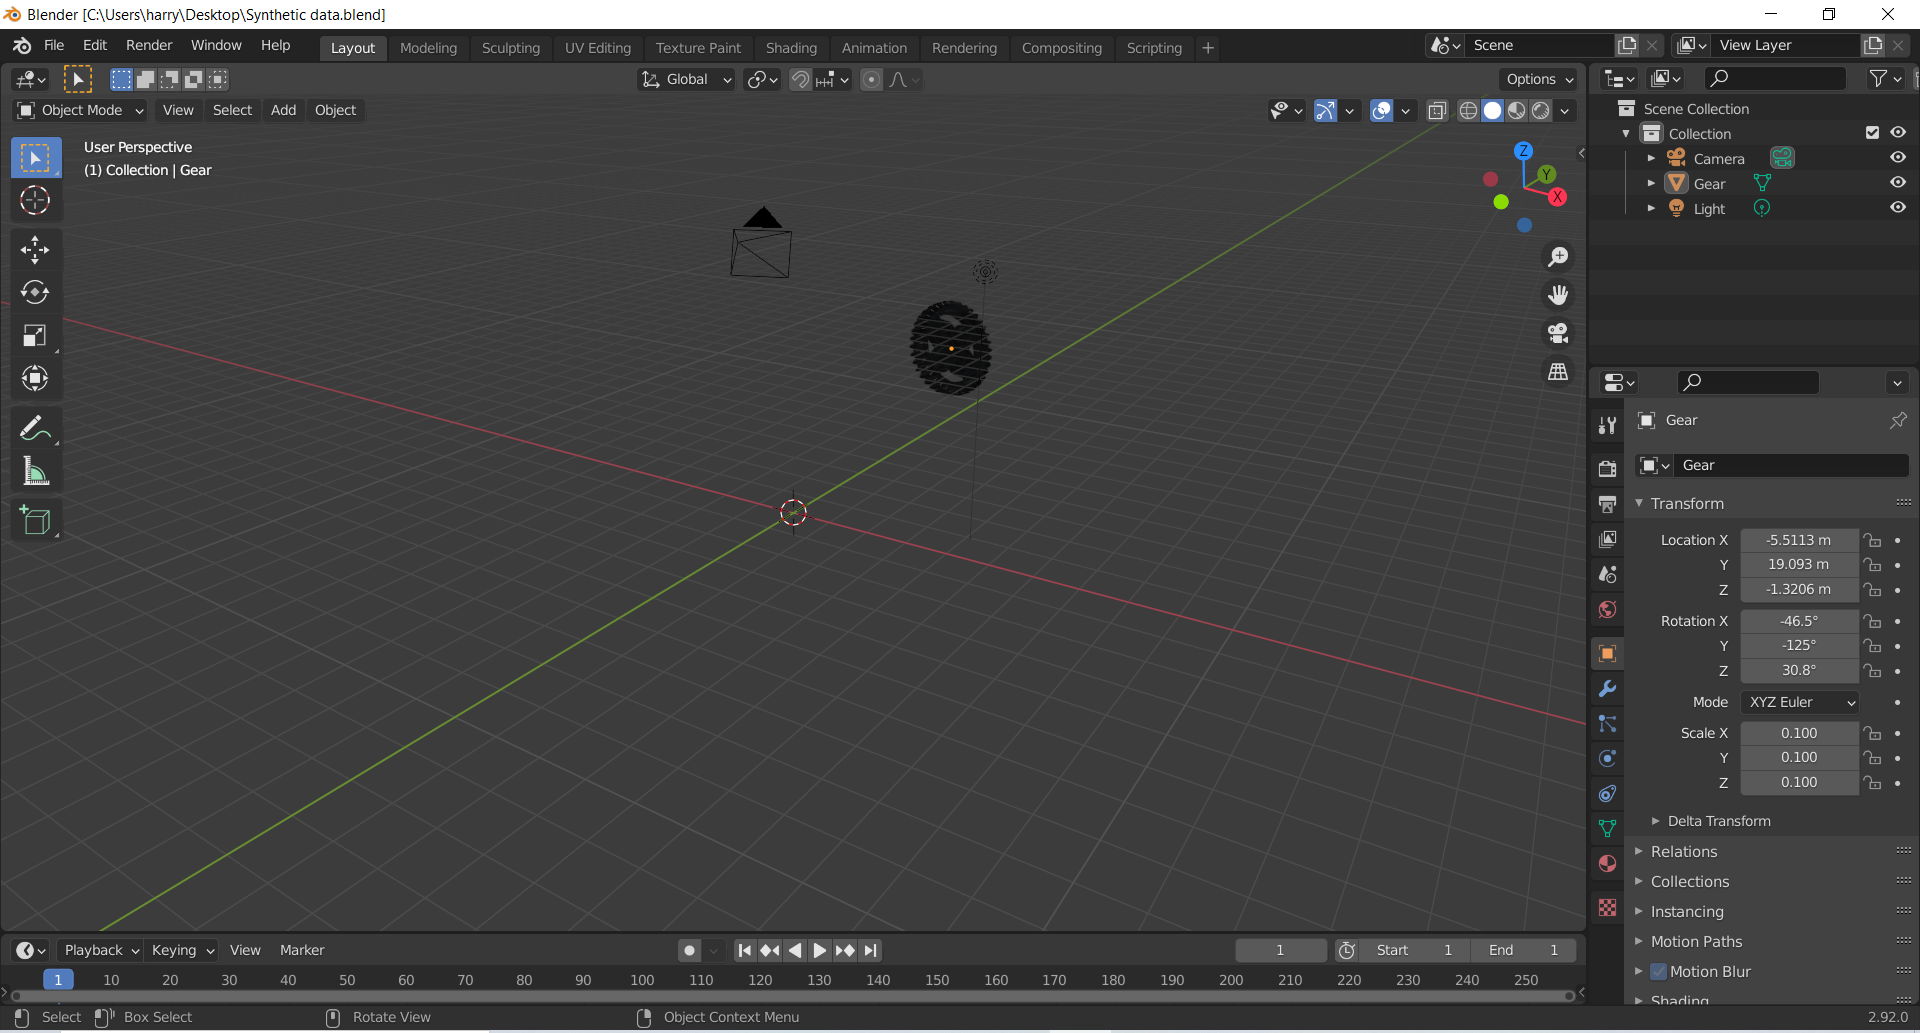

**Blender Scripting code**
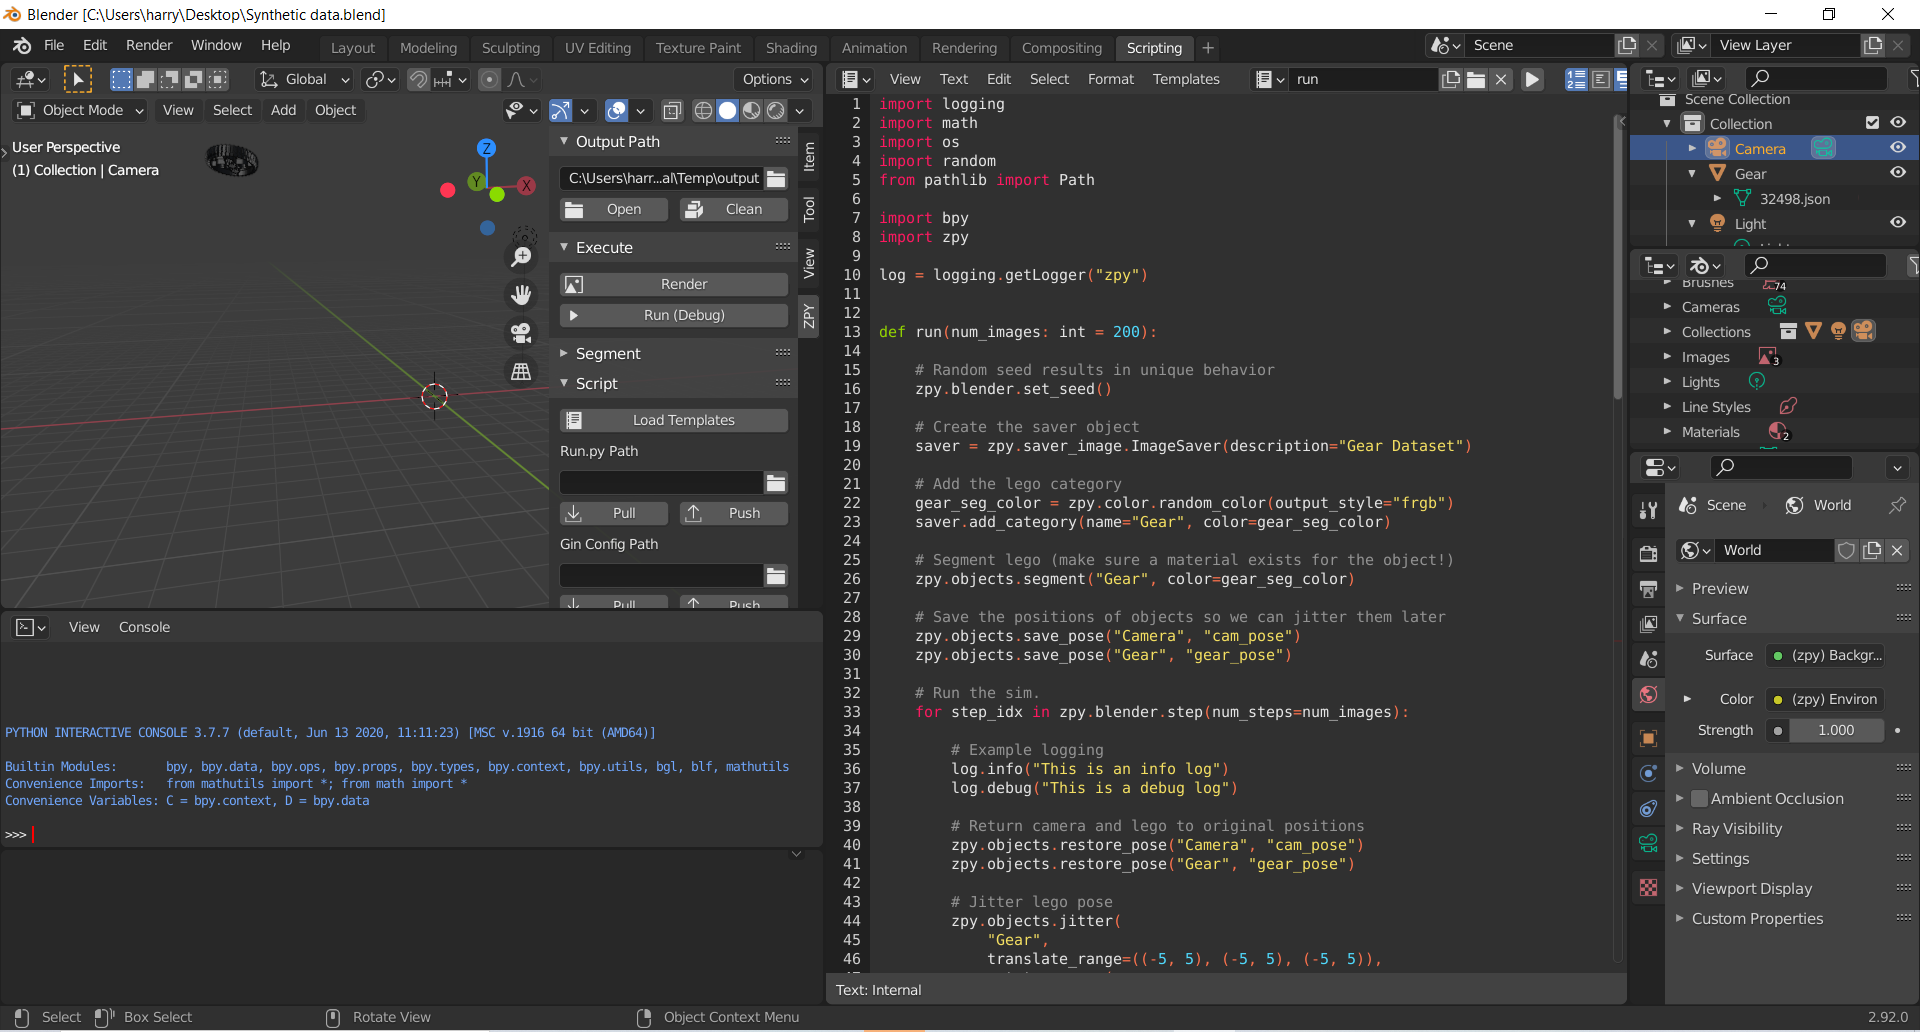
```
import logging
import math
import os
import random
from pathlib import Path

import bpy
import zpy

log = logging.getLogger("zpy")


def run(num_images: int = 200):

    # Random seed results in unique behavior
    zpy.blender.set_seed()

    # Create the saver object
    saver = zpy.saver_image.ImageSaver(description="Gear Dataset")

    # Add the lego category
    gear_seg_color = zpy.color.random_color(output_style="frgb")
    saver.add_category(name="Gear", color=gear_seg_color)

    # Segment lego (make sure a material exists for the object!)
    zpy.objects.segment("Gear", color=gear_seg_color)

    # Save the positions of objects so we can jitter them later
    zpy.objects.save_pose("Camera", "cam_pose")
    zpy.objects.save_pose("Gear", "gear_pose")

    # Run the sim.
    for step_idx in zpy.blender.step(num_steps=num_images):

        # Example logging
        log.info("This is an info log")
        log.debug("This is a debug log")

        # Return camera and lego to original positions
        zpy.objects.restore_pose("Camera", "cam_pose")
        zpy.objects.restore_pose("Gear", "gear_pose")

        # Jitter lego pose
        zpy.objects.jitter(
            "Gear",
            translate_range=((-5, 5), (-5, 5), (-5, 5)),
            rotate_range=(
                (-math.pi, math.pi),
                (-math.pi, math.pi),
                (-math.pi, math.pi),
            ),
        )

        # Jitter the camera pose
        zpy.objects.jitter(
            "Camera",
            translate_range=(
                (-5, 5),
                (-5, 5),
                (-5, 5),
            ),
        )

        # HDRIs are like a pre-made background with lighting
        zpy.hdris.random_hdri()

        # Jitter the HSV for empty and full images
        hsv = (
            random.uniform(0.49, 0.51),  # (hue)
            random.uniform(0.95, 1.1),  # (saturation)
            random.uniform(0.75, 1.2),  # (value)
        )

        # Name for each of the output images
        rgb_image_name = zpy.files.make_rgb_image_name(step_idx)
        iseg_image_name = zpy.files.make_iseg_image_name(step_idx)

        # Render image
        zpy.render.render(
            rgb_path=saver.output_dir / rgb_image_name,
            iseg_path=saver.output_dir / iseg_image_name,
            hsv=hsv,
        )

        # Add images to saver
        saver.add_image(
            name=rgb_image_name,
            style="default",
            output_path=saver.output_dir / rgb_image_name,
            frame=step_idx,
        )
        saver.add_image(
            name=iseg_image_name,
            style="segmentation",
            output_path=saver.output_dir / iseg_image_name,
            frame=step_idx,
        )
        # Add annotation to segmentation image
        saver.add_annotation(
            image=rgb_image_name,
            seg_image=iseg_image_name,
            seg_color=gear_seg_color,
            category="Gear",
        )
        # COCO Annotations
        zpy.output_coco.OutputCOCO(saver).output_annotations()


if __name__ == "__main__":

    # Set the logger levels
    zpy.logging.set_log_levels("info")

    # Parse the gin-config text block
    zpy.blender.parse_config("config")

    # Run the sim
    run()
```



**Synthetic Dataset :** https://drive.google.com/drive/folders/1rO6Gt2YgV3EJcvq5wpVG2PDQylUjP6b-?usp=sharing

**Training the model**

---






Now that we have the Data, it is time to train the model!

Firstly, we get the data (Images and their corresponding COCO annotations) from google drive and process it.

In [ ]:
#Start by connecting gdrive into the google colab

from google.colab import drive

drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO

class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [ ]:
# In my case, just added ToTensor
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

In [ ]:
import os
corpus = os.path.join("/content/gdrive/My Drive", "Lego Bricks")
# path to your own data and coco file
train_data_dir = os.path.join(corpus, "#32498")
train_coco = os.path.join(corpus, "_annotations_coco.json")

# create own Dataset
my_dataset = myOwnDataset(root=train_data_dir,
                          annotation=train_coco,
                          transforms=get_transform()
                          )

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

# Batch size
train_batch_size = 1

# own DataLoader
data_loader = torch.utils.data.DataLoader(my_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          num_workers=4,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# select device (whether GPU or CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# DataLoader is iterable over Dataset
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'boxes': tensor([[371.0100, 213.0100, 427.9900, 271.9900]]), 'labels': tensor([1]), 'image_id': tensor([248]), 'area': tensor([3360.6804]), 'iscrowd': tensor([0])}]
[{'boxes': tensor([[512.0100, 211.0100, 581.9900, 261.9900]]), 'labels': tensor([1]), 'image_id': tensor([338]), 'area': tensor([3567.5803]), 'iscrowd': tensor([0])}]
[{'boxes': tensor([[394.0100, 201.0100, 446.9900, 253.9900]]), 'labels': tensor([1]), 'image_id': tensor([100]), 'area': tensor([2806.8804]), 'iscrowd': tensor([0])}]
[{'boxes': tensor([[351.0100, 172.0100, 424.9900, 245.9900]]), 'labels': tensor([1]), 'image_id': tensor([18]), 'area': tensor([5473.0405]), 'iscrowd': tensor([0])}]
[{'boxes': tensor([[283.0100,  93.0100, 336.9900, 126.9900]]), 'labels': tensor([1]), 'image_id': tensor([236]), 'area': tensor([1834.2404]), 'iscrowd': tensor([0])}]
[{'boxes': tensor([[401.0100, 213.0100, 452.9900, 269.9900]]), 'labels': tensor([1]), 'image_id': tensor([144]), 'area': tensor([2961.8203]), 'iscrowd': tensor([0])}]

Now that we have successfully uploaded and processed our data, we can train our model

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model


# 2 classes; Only target class or background
num_classes = 2
num_epochs = 1
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Iteration: 1/200, Loss: 1.539116382598877
Iteration: 2/200, Loss: 1.3486274480819702
Iteration: 3/200, Loss: 1.2042980194091797
Iteration: 4/200, Loss: 1.0711863040924072
Iteration: 5/200, Loss: 0.9333089590072632
Iteration: 6/200, Loss: 0.7550965547561646
Iteration: 7/200, Loss: 0.6560199856758118
Iteration: 8/200, Loss: 0.5419344305992126
Iteration: 9/200, Loss: 0.37008705735206604
Iteration: 10/200, Loss: 0.8248735070228577
Iteration: 11/200, Loss: 0.2018483728170395
Iteration: 12/200, Loss: 0.4295158088207245
Iteration: 13/200, Loss: 0.16329297423362732
Iteration: 14/200, Loss: 0.12397874891757965
Iteration: 15/200, Loss: 0.19225555658340454
Iteration: 16/200, Loss: 0.25792375206947327
Iteration: 17/200, Loss: 0.4636555016040802
Iteration: 18/200, Loss: 0.3420516848564148
Iteration: 19/200, Loss: 0.34495624899864197
Iteration: 20/200, Loss: 0.25562652945518494
Iteration: 21/200, Loss: 0.2104727029800415
Iteration: 22/200, Loss: 0.2357473373413086
Iteration: 23/200, Loss: 0.27011421

You can even save the model into google drive with the below code so that you can reupload it without having to retrain the model every time you restart the runtime.

In [ ]:
#Save the model(Do not run this unless you need to update the model)
#Code has been made into a comment to prevent the accidental updating of the model
#torch.save(model, '/content/gdrive/MyDrive/Lego Bricks/AI_model.pt')


In [ ]:
#Load model
#This allows us to upload the model from google drive so that we don't have to retrain it everytime we restart the runtime
model = torch.load('/content/gdrive/MyDrive/Lego Bricks/AI_model.pt')
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

Testing the model
---
We can test the model with other images

In [ ]:
import tensorflow as tf
from PIL import Image
from torchvision import datasets, transforms
from torch.autograd import Variable
import tensorflow as tf
# Load Test image
img_path = "/content/gdrive/MyDrive/Lego Bricks/#32498/image.000191.rgb.png"
img = Image.open(img_path)
# Process image
model.eval()
img_size=640
ratio = min(img_size/img.size[0], img_size/img.size[1])
print(ratio)
imw = round(img.size[0] * ratio)
imh = round(img.size[1] * ratio)
img_transforms=transforms.Compose([transforms.Resize((imh,imw)),
  transforms.Pad((max(int((imh-imw)/2),0),
    max(int((imw-imh)/2),0), max(int((imh-imw)/2),0),
    max(int((imw-imh)/2),0)), (128,128,128)),
  transforms.ToTensor(),
  ])
image_tensor = img_transforms(img).float()
image_tensor = image_tensor.unsqueeze_(0)
input_img = Variable(image_tensor.type('torch.Tensor'))
# Test model with image
output = model(input_img)
# Extract data of the location of the box
box_coords=output[0]["boxes"].detach().numpy()[0]
# Extract data of the confidence
confidence=output[0]["scores"].detach().numpy()[0]
print(box_coords)

1.0
[447.77896 241.04114 491.8851  298.9853 ]


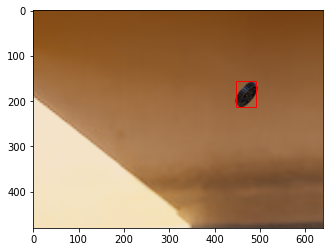

Confidence: 0.85651493


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image



# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(img)

# Create a Rectangle patch
rect = patches.Rectangle((box_coords[0], (box_coords[1])*530/600), box_coords[2]-box_coords[0], (box_coords[1]-box_coords[3]), linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()
print("Confidence: "+str(confidence))

**Camera**
---
Lastly, we can deploy the model to work with real world data



In [ ]:
#import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode

In [ ]:
#google colab code snippet (for web cam live imaaging)
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  #get photo data
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg
'module' object is not callable
1.0
[{'boxes': tensor([[107.9398, 480.9426, 210.7234, 537.4263],
        [228.5090, 428.1148, 320.8969, 520.9116],
        [133.4592, 468.7034, 184.5365, 536.4591],
        [118.4308, 493.5385, 190.4911, 530.3535],
        [204.4969, 474.6388, 325.5829, 535.6575],
        [128.3406, 446.4553, 224.3929, 533.5155],
        [120.7048, 477.7488, 193.0914, 515.4177],
        [115.4742, 424.1231, 179.1449, 539.1984],
        [101.0705, 454.3253, 200.2489, 519.1349],
        [187.4430, 444.8319, 285.6208, 529.1537],
        [266.8914, 411.4848, 332.9481, 536.1700],
        [117.5868, 475.2055, 162.7181, 541.2529],
        [119.1467, 272.5306, 184.6063, 310.6894],
        [236.1066, 405.1897, 321.3670, 486.8782],
        [150.2814, 475.1369, 293.1959, 533.5269],
        [136.0595, 455.5811, 276.4890, 515.8782],
        [206.3975, 410.8116, 296.8682, 493.8745],
        [103.4526, 433.2304, 208.9857, 497.8299],
        [143.7203, 402.6566, 211.3

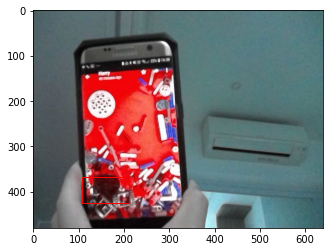

Confidence: 0.7949818


In [ ]:
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))
img = Image.open("/content/photo.jpg")
model.eval()
img_size=640
ratio = min(img_size/img.size[0], img_size/img.size[1])
print(ratio)
imw = round(img.size[0] * ratio)
imh = round(img.size[1] * ratio)
img_transforms=transforms.Compose([transforms.Resize((imh,imw)),
  transforms.Pad((max(int((imh-imw)/2),0),
    max(int((imw-imh)/2),0), max(int((imh-imw)/2),0),
    max(int((imw-imh)/2),0)), (128,128,128)),
  transforms.ToTensor(),
  ])
image_tensor = img_transforms(img).float()
image_tensor = image_tensor.unsqueeze_(0)
input_img = Variable(image_tensor.type('torch.Tensor'))
# Test model with image
output = model(input_img)
print(output)


# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(img)
# Extract data of the location of the box

try:
  for i in range(1):
    box_coords=output[0]["boxes"].detach().numpy()[i]
    confidence=output[0]["scores"].detach().numpy()[i]

    # Create a Rectangle patch
    rect = patches.Rectangle((box_coords[0], (box_coords[1])*530/600), box_coords[2]-box_coords[0], (box_coords[1]-box_coords[3]), linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
except Exception as err:
  # Errors will be thrown if nothing is detected
  print("Nothing detected")



plt.show()
print("Confidence: "+str(confidence))